In [22]:
%load_ext autoreload
%autoreload 2
from cfpilot.mapping import GridMap
from cfpilot.planning.DStarLite.d_star_lite import DStarLite, Node
from cfpilot.planning.CubicSpline.cubic_spline_planner import CubicSpline2D, calc_spline_course
from cfpilot.planning.CubicSpline.spline_continuity import Spline2D
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Grid Map Generation for Crazyflie

This notebook demonstrates how to use `GridMap` from a given environment for the Crazyflie project.

**Map Configuration:**
- **Width:** 5 m
- **Height:** 3 m
- **Resolution:** 0.1 m

The image below illustrates the environment used for map generation.

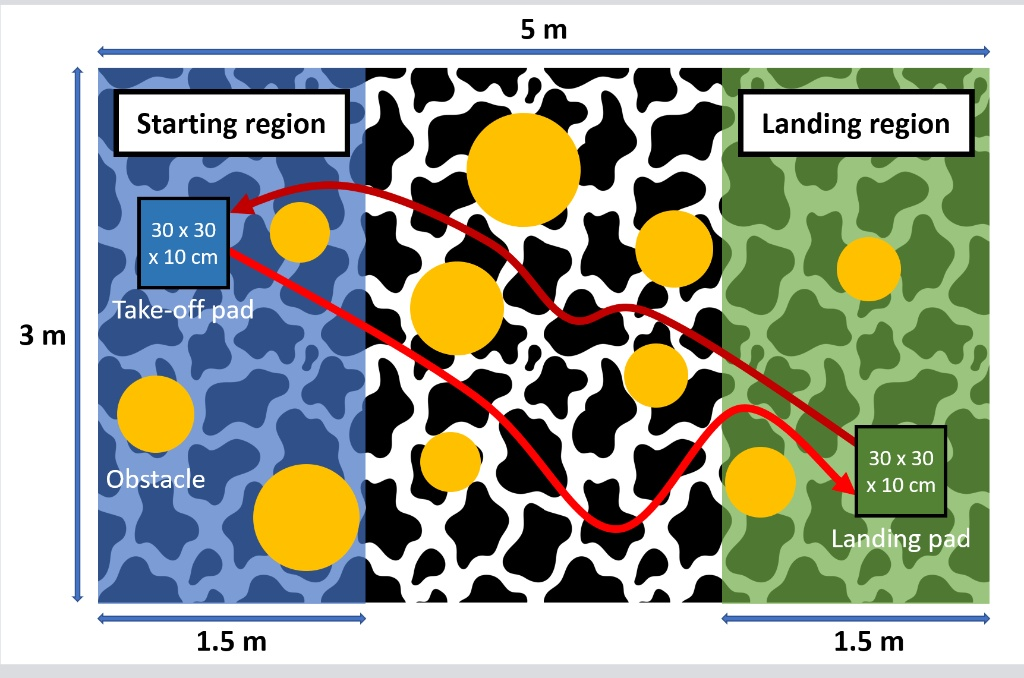

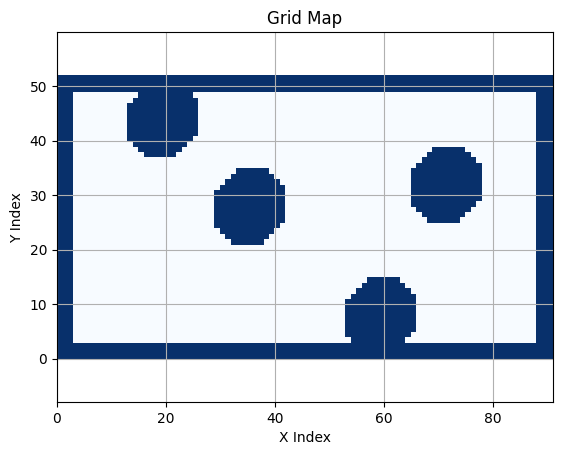

In [3]:
resolution = 0.05  # [m]
width = 4.6  # [m]
height = 2.6  # [m]
grid_map = GridMap(width=int(width / resolution), height=int(height / resolution), resolution=resolution, center_x=width/2, center_y=height/2)

# Add obstacles using the new method
grid_map.add_obstacle(center_x=1.0, center_y=2.2, radius=0.3)
grid_map.add_obstacle(center_x=1.8, center_y=1.4, radius=0.3)
grid_map.add_obstacle(center_x=3.0, center_y=0.4, radius=0.3)
grid_map.add_obstacle(center_x=3.6, center_y=1.6, radius=0.3)
grid_map.occupy_boundaries(boundary_width=2)


grid_map.expand_grid(occupied_val=0.5)



heat_map = grid_map.plot_grid_map(use_world_coords=False)
plt.grid(True)

## D* Lite and Path Planning

**D* Lite** is an incremental heuristic search algorithm commonly used for path planning in dynamic environments. It efficiently replans paths when the environment changes, making it suitable for robotics applications where obstacles may appear or move.

**Path Planning** involves finding a feasible route from a start position to a goal position while avoiding obstacles. In this notebook, D* Lite is used to compute a path on a grid map, taking into account both static and dynamic obstacles.

In [14]:
# find ox and oy by indices of values over than 0.5 in grid_map.data
ox, oy = np.where(grid_map.data > 0.5)
planner = DStarLite(ox=ox, oy=oy)
start_index = grid_map.get_xy_index_from_xy_pos(x_pos=0.7, y_pos=1.3)
goal_index = grid_map.get_xy_index_from_xy_pos(x_pos=3.9, y_pos=0.7)
start = Node(start_index[0], start_index[1])
goal = Node(goal_index[0], goal_index[1])

path_found, pathx, pathy = planner.main(start=start, 
                                        goal=goal,
                                        spoofed_ox=[], 
                                        spoofed_oy=[])

Initializing
Path found


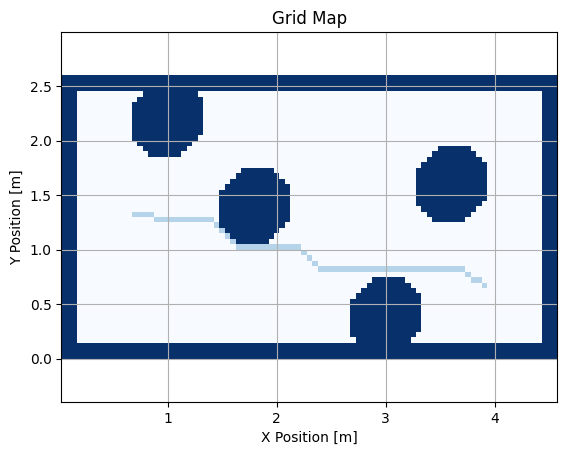

In [15]:
grid_map.data[pathx, pathy] = 0.3 # show the path with light color
heat_map = grid_map.plot_grid_map(use_world_coords=True)
plt.grid(True)


In [28]:
pos_x, pos_y = grid_map.get_xy_poss_from_xy_indexes(pathx, pathy)

In [30]:
ds = 0.1  # [m] distance between each interpolated point
spline = CubicSpline2D(pos_x, pos_y)

rx, ry, ryaw, rk, s = calc_spline_course(pos_x, pos_y, ds=ds)

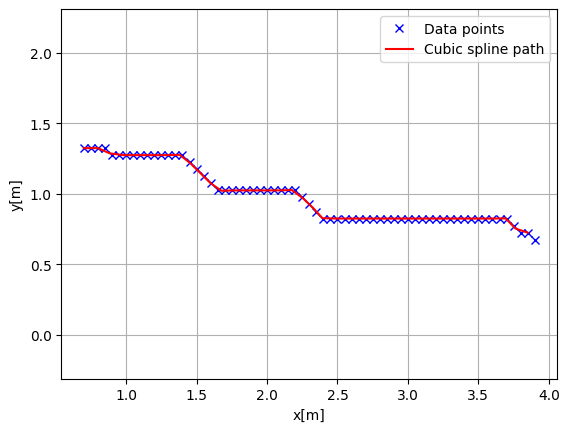

In [31]:
plt.subplots(1)
plt.plot(pos_x, pos_y, "xb", label="Data points")
plt.plot(rx, ry, "-r", label="Cubic spline path")
plt.grid(True)
plt.axis("equal")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.legend();

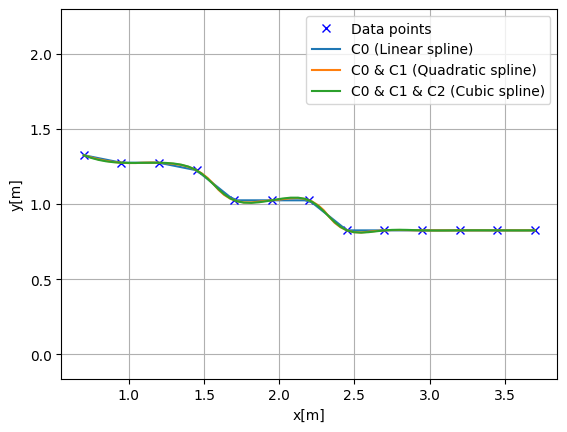

In [ ]:
plt.subplots(1)
plt.plot(pos_x, pos_y, "xb", label="Data points")
ds = 0.05
for (kind, label) in [("linear", "C0 (Linear spline)"),
                        ("quadratic", "C0 & C1 (Quadratic spline)"),
                        ("cubic", "C0 & C1 & C2 (Cubic spline)")]:
    rx, ry = [], []
    sp = Spline2D(pos_x, pos_y, kind=kind)
    s = np.arange(0, sp.s[-1], ds)
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
    plt.plot(rx, ry, "-", label=label)

plt.grid(True)
plt.axis("equal")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.legend()
plt.show()